# Fairy circle formation by H<sub>2</sub>S inhibition

# Plant-sulfide model

The model describes the dynamics of a plant $P$ and sulfide $S$, using the following differential equations:

$$
\begin{aligned}
\frac{\partial P}{\partial t}&= r P (1 - \frac{P}{K}) - c P S + D_{p} \Delta P\\
\frac{\partial S}{\partial t}&= \xi\Big[\varepsilon P - d \frac{k_{s}}{P + k_{s}} S\Big] + D_{s} \Delta S
\end{aligned}
$$

Here, $r$ is the plant maximal growth rate, $K$ is the plant's carrying capcity, $c$ is the maximal death rate caused by sulfide, $k_{S}$ is the plant biomass at which sulfide toxification is half maximal, $\varepsilon$ is the sulfide prodction increase for every unit of plant growth, and $d$ is the detoxification rate.  $\xi$ is a non-negative dimensionless
parameter that quantifies the difference between
orders of magnitude for the time scales of plant ($P$) and sulfide ($S$).

In [1]:
from __future__ import absolute_import, print_function
import time
import numpy as np
import pyopencl as cl
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib import rcParams
import matplotlib.animation as animation

# Widening the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

rcParams['figure.dpi'] = 300
rcParams['font.size'] = 16
rcParams['font.family'] = 'StixGeneral'
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)   # fontsize of the figure title

### Parameter definition 

In [2]:
# # parameters
Dp  = 0.002
Ds  = Dp/10.0
K   = 10.0
r   = 0.8
c   = 10.0
d   = 0.5
eps = 0.004 # 0.004
ks  = 0.2
xi  = 0.1

### Simulation settings

In [3]:
length    = 50.0      # 2.5 Length of the physical landscape
n         = 512       # Size of the 2D grid
endtime   = 1000.0     # end time
dT        = 0.05      # calculate time step
nplot     = 1000
plottime  = endtime/nplot
nsteps    = np.ceil(plottime/dT).astype(int)    #number of time steps

### Precalculations

In [4]:
dX = 2*length/n      # Spatial step size
dY = 2*length/n      # Spatial step size
Grid_Width  = n
Grid_Height = n
# %% Reporting in the simulation on the console
print(" Current grid dimensions: %d x %d cells\n" % (Grid_Width, Grid_Height));

 Current grid dimensions: 512 x 512 cells



### Defining the device that is used

In [5]:
# Setting up the OpenCL context
DeviceNr = 1   # 0 = GTX 960M
platform = cl.get_platforms()
Devices  = platform[0].get_devices()  # 0 = GPU
context  = cl.Context([Devices[DeviceNr]])
queue    = cl.CommandQueue(context)
mf       = cl.mem_flags # Memory flags are set
print(" Compute Device: %s\n" % Devices[DeviceNr].name)

 Compute Device: AMD Radeon Pro Vega 64X Compute Engine



### Numerical equilibrium

In [6]:
from scipy.optimize import fsolve
def func(x):
    return [r*(1.0 - x[0]/K)*x[0] - c*x[0]*x[1],
            xi*(eps*x[0] - d*ks*x[1]/(x[0]+ks))]
root = fsolve(func, [1, 1])
root

array([1.22828569, 0.07017371])

### Initial values

In [7]:
# data_Ps=np.load('Model1Ps.npy')
# data_Ss=np.load('Model1Ss.npy')

# data_Ps[:,:,100]
# data_Ss[:,:,100]

### Numerical equilibrium
from scipy.optimize import fsolve
def func(x):
    return [r*(1.0 - x[0]/K)*x[0] - c*x[0]*x[1],
            xi*(eps*x[0] - d*ks*x[1]/(x[0]+ks))]
root = fsolve(func, [1, 1])
### Initial values
im      = np.zeros((n, n))+root[1]*0.6
S_host  = (im.reshape(n*n)).astype(np.float32)
S_g     = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=S_host)

im  = np.zeros((n,n))
x   = np.linspace(0,n,n)
y   = np.linspace(0,n,n)
X,Y = np.meshgrid(x, y)
im  = np.sin(0.05*X)*np.sin(0.05*Y)
im[im>=0.99]=1.0
im[im<0.99]=0.0
# im  = np.zeros((n,n)) + np.mean(im)
P_host=(im.reshape(n*n)).astype(np.float32)
P_g       = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=P_host)

### Loading the spatial functions from the ipython file

In [8]:
with open('SpatialFunctions_iPy.cl', 'r') as myfile:
   SpatialFunctions = myfile.read()

In [9]:
# List of parameters for the OpenCL kernel. Seperate with comma without spaces
# Setting up the parameters for the Kernel

PassVars="K,Dp,Ds,r,c,d,eps,xi,ks,dX,dY,dT,Grid_Width,Grid_Height"

PassVals=eval(PassVars)
PassVars=PassVars.split(',')
Params=""

for ii in range(len(PassVals)):
    Params = Params+"#define " + PassVars[ii] + " " + str(PassVals[ii]) + " \n"

### Defining the OpenCL simulation kernel

In [10]:
ComputeCode = """

///////////////////////////////////////////////////////////////////////////////
// Simulation kernel
///////////////////////////////////////////////////////////////////////////////   

__kernel void SimulationKernel (__global float* P, __global float* S)
{

    size_t current  = get_global_id(0);
    size_t row      = floor((float)current/(float)Grid_Width);
    size_t column   = current%Grid_Width;

        if (row > 0 && row < Grid_Width-1 && column > 0 && column < Grid_Height-1)
            {                
             float dPdt = r*(1 - P[current]/K)*P[current] - c*P[current]*S[current] + Dp*d2_dxy2(P);
             float dSdt = xi*(eps*P[current] - d*ks*S[current]/(P[current]+ks)) + Ds*d2_dxy2(S);
             
             P[current] = P[current] + dPdt*dT;
             S[current] = S[current] + dSdt*dT;
            }
            
        // HANDLE Boundaries
        else 
            {
             PeriodicBoundaries(P);
             PeriodicBoundaries(S);
            }

} // End SimulationKernel
"""

### Here the kernel is compiled

In [11]:
program = cl.Program(context, Params + SpatialFunctions + ComputeCode).build()

In [12]:
from ipywidgets import FloatProgress
from IPython.display import display

# Setting up a progress bar for the simulation
print("Progress :");
PB = FloatProgress(min=0, max=nplot); display(PB) 

Ps=np.zeros((Grid_Width, Grid_Height, nplot))
Ss=np.zeros((Grid_Width, Grid_Height, nplot))
APB=np.zeros((nplot))
ASB=np.zeros((nplot))
delta=np.zeros((nplot))
# Set up simulation parameters
global_size = P_host.shape

# Start the timer:
start_time = time.time()

# Starting the loop
for ii in range(nplot):
    APB[ii]    = np.mean(P_host.reshape(Grid_Width, Grid_Height))
    ASB[ii]    = np.mean(S_host.reshape(Grid_Width, Grid_Height))
    # The simulation
    for jj in range(nsteps):      
        program.SimulationKernel(queue, global_size, None, P_g, S_g)

    # Get the data from the GPU
    cl.enqueue_copy(queue, P_host, P_g)
    cl.enqueue_copy(queue, S_host, S_g)
    
    # We store the state of the system for <NumPlot> different times.
    Ps[:,:,ii] = P_host.reshape(Grid_Width, Grid_Height)
    Ss[:,:,ii] = S_host.reshape(Grid_Width, Grid_Height)
    delta[ii]  = 1-P_host.reshape(Grid_Width, Grid_Height)[256,256]/np.max(P_host.reshape(Grid_Width, Grid_Height))
    
    PB.value += 1 # signal to increment the progress bar

# Determining the time that we used for the simulation
elapsed_time = time.time() - start_time    
print(" Simulation took      : %1.1f (s)" % (elapsed_time))

Progress :


FloatProgress(value=0.0, max=1000.0)

 Simulation took      : 15.4 (s)


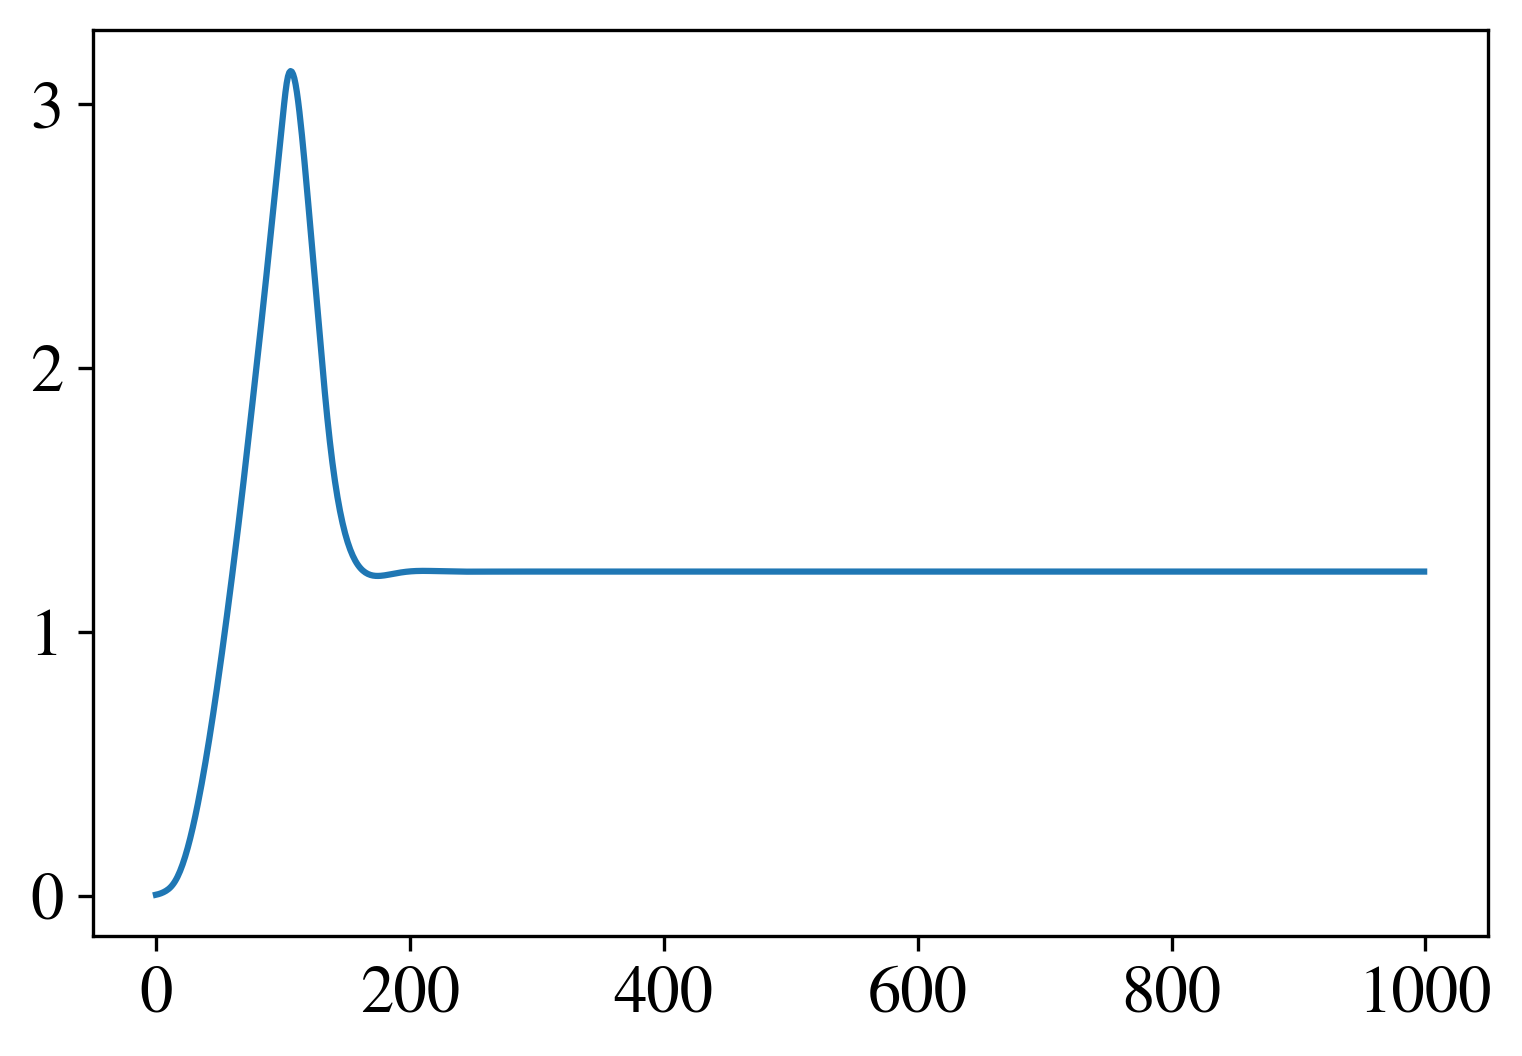

In [13]:
# plt.plot(delta)
# np.save('delta1.npy',delta)
# plt.savefig('delta1.pdf')
plt.plot(APB)
# plt.plot(ASB)
# np.save('APB2.npy',APB)
# np.save('Ps.npy',Ps[:,:,:])
# np.save('Ns.npy',Ns[:,:,:])

### Plotting the results

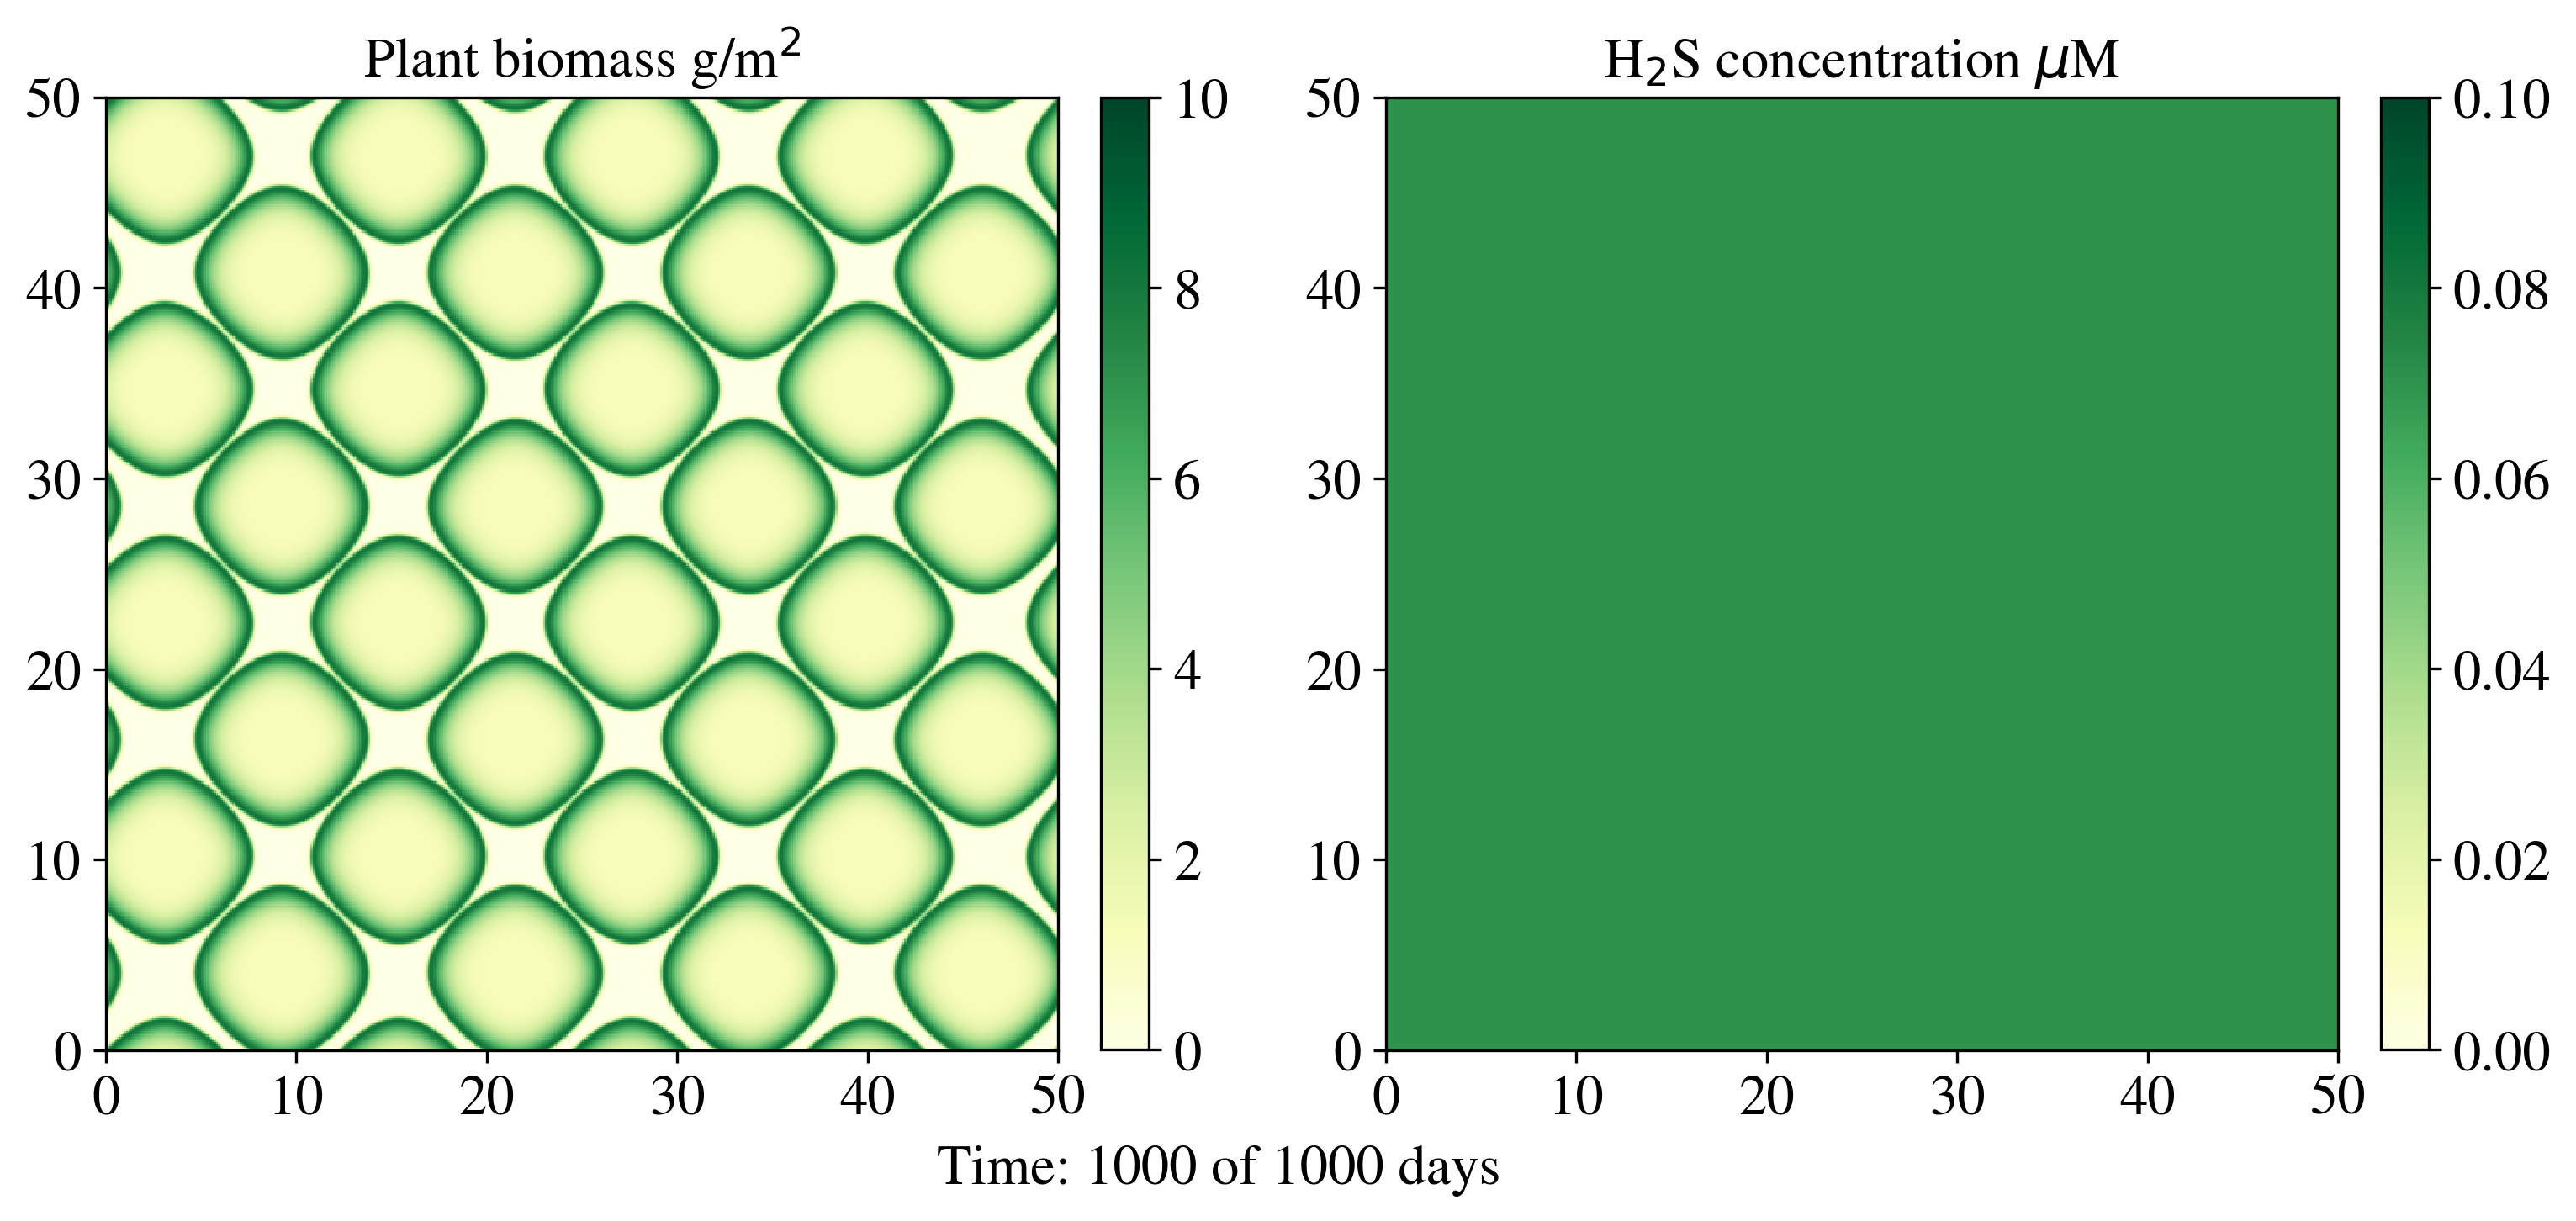

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

im0 = ax[0].imshow(Ps[:,:,100],cmap='YlGn',extent=[0,length,0,length], clim=(0,K));
plt.colorbar(im0, ax=ax[0],fraction=0.046,pad=0.04);ax[0].set_title('Plant biomass g/m$^2$');

im1 = ax[1].imshow(S_host.reshape(n,n),cmap='YlGn',extent=[0,length,0,length], clim=(0,0.1));
plt.colorbar(im1, ax=ax[1],fraction=0.046,pad=0.04);ax[1].set_title('H$_2$S concentration $\mu$M');

text=fig.suptitle("Time: %1.0f of %1.0f days" % (endtime, endtime), x=0.5, y=0.05, fontsize=16);

plt.savefig('MultiFCs1.png', dpi=800)

# plt.savefig('MultiFCs11.png', dpi=800)


In [15]:
from scipy import io
io.savemat('plant1.mat', {'plant1': APB})
# io.savemat('plant11.mat', {'plant11': APB})
#data = io.loadmat(matfn)

In [16]:
np.save('Model1Ps.npy',Ps[:,:,:])
np.save('Model1Ss.npy',Ss[:,:,:])

The End, Kang, 2020.10.10, ECNU.